# DeepAR Example

In this notebook we reproduce the code of the [GluonTS](https://gluon-ts.mxnet.io/index.html) guide [Get Started: A Quick Example](https://gluon-ts.mxnet.io/#get-started-a-quick-example) of a [DeepAR](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html) example.

## Prepare Notebook

In [1]:
# Main libraries.
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
# GluonTS
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.trainer import Trainer

## Example 1

### Read Data

In [2]:
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv'
df_raw = pd.read_csv(url, header=0, index_col=0)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15831 entries, 2015-02-26 21:42:53 to 2015-04-22 20:52:53
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   15831 non-null  int64
dtypes: int64(1)
memory usage: 247.4+ KB


In [3]:
df_raw.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


In [4]:
# Format data.
df = df_raw \
        .reset_index() \
        .assign(timestamp = lambda x: pd.to_datetime(x['timestamp']))

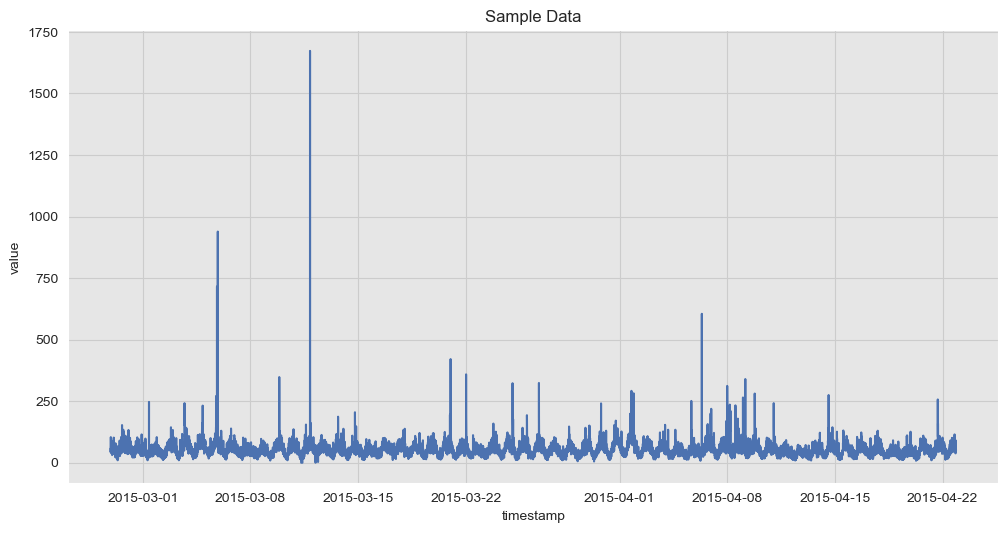

In [5]:
# Plot
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='value', data=df, ax=ax)
ax.set(title='Sample Data');

### Define Dataset

In [6]:
train_test_split = '2015-04-05 00:00:00'

params = {
    'start': df['timestamp'][0], 
    'target': df.query(f'timestamp < "{train_test_split}"')['value']
}

data = common.ListDataset([params],freq='5min')

### Train Model

In [7]:
trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(
    freq='5min', 
    prediction_length=12, 
    trainer=trainer
)

predictor = estimator.train(training_data=data)

100%|██████████| 50/50 [00:04<00:00, 10.30it/s, epoch=10/10, avg_epoch_loss=3.96]


In [8]:
prediction = next(predictor.predict(data, num_samples=500))
print(prediction.mean)

[51.415615 51.738186 47.46099  48.179764 45.709217 46.1583   45.390366
 44.433434 46.140438 45.092384 47.07406  45.935635]


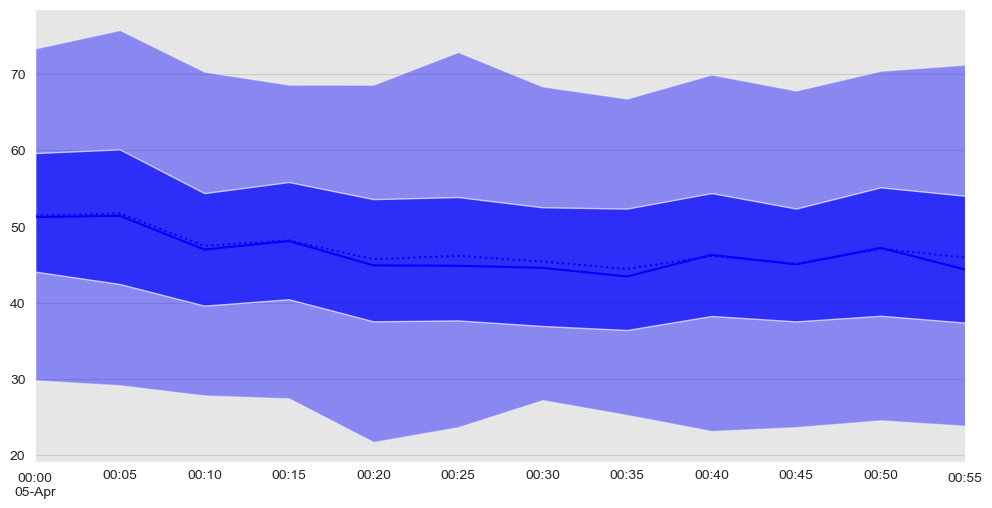

In [9]:
# We plot the predictions from one sample step:
prediction.plot(show_mean=True)

In [10]:
# Get other sample.
prediction = next(predictor.predict(data))
print(prediction.mean)

[49.700596 51.066086 45.60265  45.65691  44.549824 46.555588 44.40982
 41.52508  44.32649  46.095062 47.427246 45.490406]


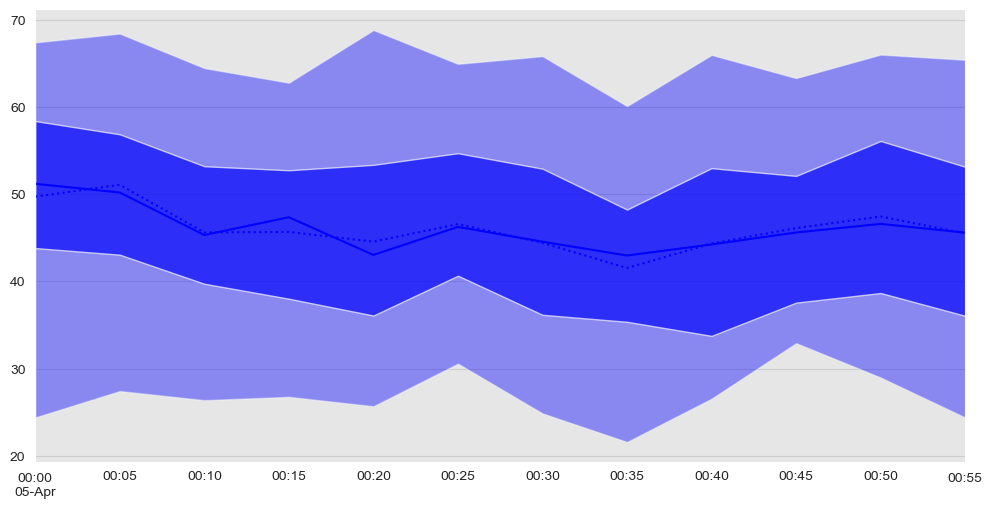

In [11]:
prediction.plot(show_mean=True)

Let us not generate many samples:

In [12]:
samples_list = []

for i in range(100):
    samples_list.append(
        list(predictor.predict(data, num_samples=200))[0].samples
    )

In [13]:
prediction_samples = np.concatenate(samples_list, axis=0)
prediction_samples.shape

(20000, 12)

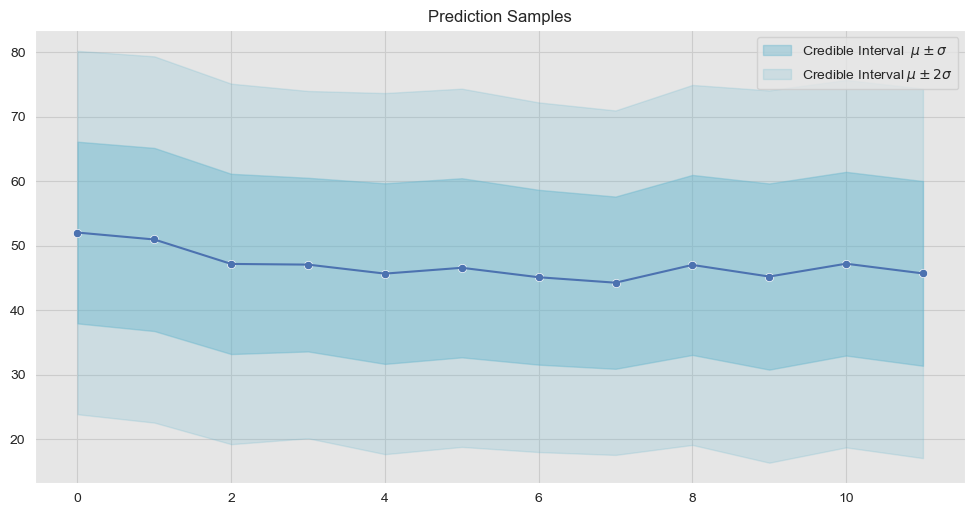

In [14]:
# Plot
xrange = range(prediction_samples.shape[1])
prediction_samples_mean = prediction_samples.mean(axis=0)
prediction_samples_std = prediction_samples.std(axis=0)
prediction_samples_mean_plus = prediction_samples_mean + prediction_samples_std 
prediction_samples_mean_minus = prediction_samples_mean - prediction_samples_std 
prediction_samples_mean_2plus = prediction_samples_mean + 2*prediction_samples_std 
prediction_samples_mean_2minus = prediction_samples_mean - 2*prediction_samples_std 

fig, ax = plt.subplots() 
ax.fill_between(
    x=xrange, 
    y1=prediction_samples_mean_minus , 
    y2=prediction_samples_mean_plus , 
    color=sns_c[9], 
    alpha = 0.4, 
    label='Credible Interval  $\mu \pm \sigma$'
)
ax.fill_between(
    x=xrange, 
    y1=prediction_samples_mean_2minus , 
    y2=prediction_samples_mean_2plus , 
    color=sns_c[9], 
    alpha = 0.2, 
    label='Credible Interval $\mu \pm 2\sigma$'
)
sns.lineplot(x=xrange, y = prediction_samples_mean, ax=ax)
sns.scatterplot(x=xrange, y = prediction_samples_mean, ax=ax)
ax.set(title='Prediction Samples');